In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
from pandas import Series, DataFrame
%matplotlib inline

In [2]:
!pip install fuzzywuzzy

In [3]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Import data from milestone 2

In [5]:
data = pd.read_csv('/content/drive/My Drive/Ada Project/results_ms_2.csv')
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,code,product_name,packaging,packaging_tags,brands_tags,categories_tags,categories_en,origins,manufacturing_places,labels_tags,labels_en,purchase_places,countries_en,ingredients_text,allergens,traces_tags,traces_en,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_2,states_tags,states_en,main_category_en,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000000031,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,"en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000001111111111,Sfiudwx,NaN,NaN,watt,fr:xsf,fr:xsf,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,"en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",fr:xsf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,"en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,88.0,0.0,0.0,NaN,NaN,4.8,0.4,NaN,0.2,2.04,0.816,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000178,Mini coco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,"en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,251.0,3.0,1.0,NaN,NaN,10.0,3.0,NaN,2.0,1.15,0.460,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000208,Pistou d'ail des ours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,"en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Study of the brands in each country

In [6]:
data_country_brand = data[['brands_tags', 'countries_en']].dropna()
data_country_brand.shape[0]

404428

##France

In [0]:
data_france_brand = data_country_brand[data_country_brand['countries_en'] == 'France']['brands_tags']

In [8]:
data_france_brand.describe()

count     196910
unique     35345
top       auchan
freq        5609
Name: brands_tags, dtype: object

In [9]:
data_france_brand = data_france_brand.value_counts()
data_france_brand = data_france_brand[data_france_brand > 2]
data_france_brand.shape[0]

7820

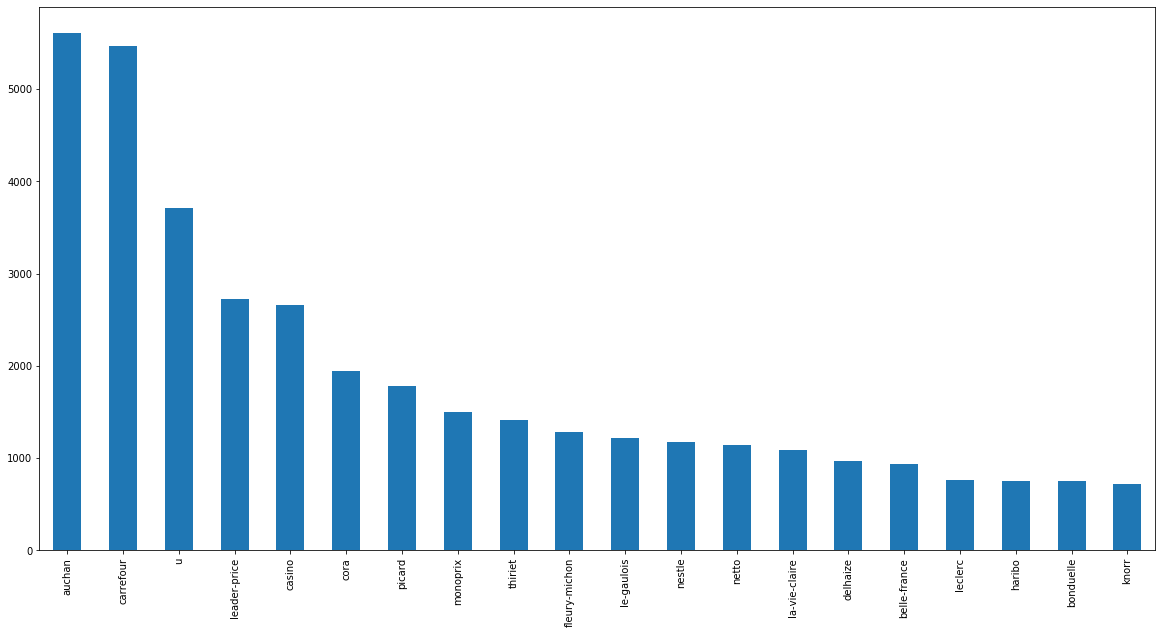

In [10]:
data_france_brand.head(20).plot(kind="bar", figsize=(20,10))

We can clearly see the hegemony of auchan and carrefour in the OFF dataset for France, followed by u, leader price and casino. We can also see that the large majority of the brands are only represented once or twice. This shows how the retailers dominate the market of food, in comparison with the simple brands like fleury-michon or even nestlé.

##USA

In [0]:
data_us_brand = data_country_brand[data_country_brand['countries_en'] == 'United States']['brands_tags']

In [12]:
data_us_brand = data_us_brand.value_counts()
data_us_brand = data_us_brand[data_us_brand > 2]
data_us_brand.shape[0]

6178

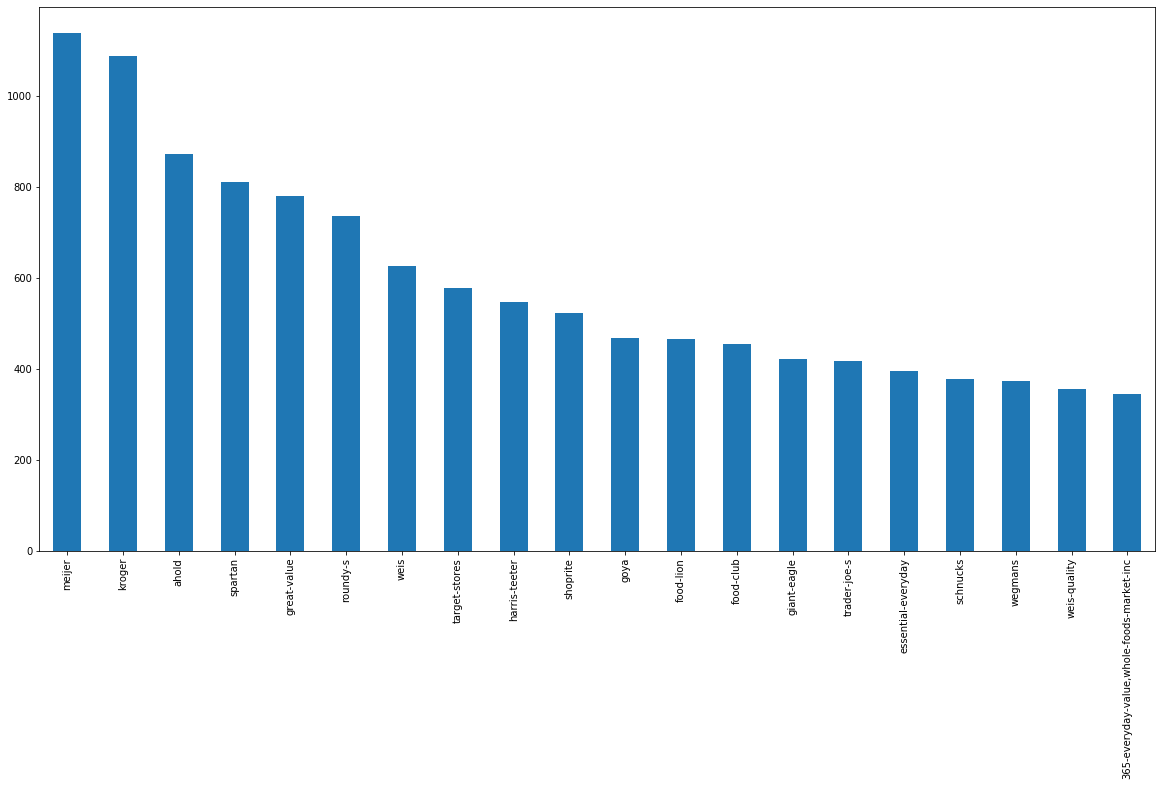

In [13]:
data_us_brand.head(20).plot(kind="bar", figsize=(20,10))

Here, we can see quite the same thing, that is to say; stores have a large share of the market in this dataset compared to productor-only brands.

#Study of the ecological footprint of the different major brands

In [84]:
us_sample = data_us_brand.head(20).index
fr_sample = data_france_brand.head(20).index
us_sample = ['meijer', 'kroger', 'ahold', 'spartan', 'great-value', 'roundy-s',
       'weis', 'target-stores', 'harris-teeter', 'shoprite', 'goya',
       'food-lion', 'food-club', 'giant-eagle', 'trader-joe-s',
       'essential-everyday', 'schnucks', 'wegmans', 'weis-quality',
       '365-everyday-value']
sample_comp = ['auchan','365-everyday-value', 'belle-france','essential-everyday', 'bonduelle','foodlion', 'carrefour','goya', 'casino','great-value', 'cora','kroger', 'delhaize','meijer',
       'fleury-michon','schnuks','haribo','targets-stores','knorr','trader-joe']
len(sample_comp)


20

##France

In [0]:
data_major_brands_fr = data[data.brands_tags.isin(fr_sample)]

In [16]:
data_major_brands_fr.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,27151.000000,27151.000000,39389.000000,38906.000000,39031.000000,92.000000,51.000000,39017.000000,39168.000000,19216.000000,39267.000000,38632.000000,38631.000000,146.000000,409.000000,547.000000,99.000000,24976.000000,24976.000000
mean,0.025634,0.125999,620.473729,5.726905,2.166307,0.060233,0.028127,16.206029,7.118467,1.732657,7.390858,0.798336,0.318675,0.000141,0.020650,0.127381,0.003423,4.288597,3.675168
std,0.160588,0.415357,413.518914,6.464806,2.935791,0.074364,0.089925,19.725173,11.609604,1.894724,7.318726,0.910092,0.363676,0.000152,0.019743,0.123761,0.004513,6.949513,6.905029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,272.000000,0.500000,0.100000,0.000000,0.000000,2.500000,0.800000,0.500000,1.500000,0.100000,0.040000,0.000069,0.012000,0.093000,0.000785,0.000000,-1.000000
50%,0.000000,0.000000,532.000000,3.200000,0.900000,0.000000,0.000000,9.600000,2.400000,1.300000,4.800000,0.630000,0.252000,0.000120,0.020000,0.120000,0.001200,3.000000,2.000000
75%,0.000000,0.000000,937.000000,8.900000,2.900000,0.100000,0.001150,21.000000,8.200000,2.400000,11.000000,1.200000,0.480000,0.000155,0.022200,0.120000,0.003405,10.000000,8.000000
max,2.000000,5.000000,1500.000000,31.700000,14.600000,0.300000,0.378000,92.000000,59.500000,17.000000,32.100000,10.900000,2.680000,0.001067,0.217000,1.285000,0.017000,26.000000,26.000000


In [0]:
data_major_brands_fr_cleaned = data_major_brands_fr[pd.notnull(data_major_brands_fr['packaging'])]

In [18]:
data_major_brands_fr_cleaned.describe()

,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,16395.000000,16395.000000,16546.000000,16478.000000,16424.000000,40.000000,9.000000,16471.000000,16443.000000,11370.000000,16513.000000,16299.00000,16298.000000,86.000000,306.000000,391.000000,33.000000,15074.000000,15074.000000
mean,0.022019,0.127722,603.958017,5.602526,2.117042,0.106035,0.134589,15.706960,6.743299,1.767197,7.141465,0.81230,0.323406,0.000187,0.021464,0.137279,0.005816,4.012273,3.499138
std,0.148813,0.416401,406.117201,6.326177,2.893282,0.071119,0.183679,18.968285,11.196270,1.871014,7.070719,0.93454,0.372979,0.000163,0.014421,0.133147,0.005240,7.040823,7.064415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.004180,0.000400,0.000225,-14.000000,-14.000000
25%,0.000000,0.000000,260.250000,0.500000,0.100000,0.092850,0.000000,2.700000,0.800000,0.500000,1.500000,0.10000,0.040000,0.000120,0.015000,0.120000,0.002100,-1.000000,-1.000000
50%,0.000000,0.000000,519.000000,3.200000,0.900000,0.100000,0.012000,9.600000,2.400000,1.400000,4.800000,0.66000,0.260000,0.000120,0.020000,0.120000,0.003600,3.000000,2.000000
75%,0.000000,0.000000,906.000000,8.700000,2.800000,0.162500,0.378000,20.000000,7.000000,2.500000,10.300000,1.20000,0.480000,0.000196,0.024000,0.123000,0.008000,10.000000,8.000000
max,2.000000,4.000000,1500.000000,31.700000,14.600000,0.200000,0.378000,90.000000,59.500000,16.000000,32.100000,10.90000,2.680000,0.001067,0.217000,1.285000,0.017000,24.000000,24.000000


In [19]:
data_major_brands_fr_cleaned['packaging'].value_counts().head()

Conserve               480
Frais                  475
Bouteille,Plastique    301
conserve               256
Sachet,Plastique       252
Name: packaging, dtype: int64

In [20]:
data_major_brands_fr_cleaned['packaging'] = data_major_brands_fr_cleaned['packaging'].apply(lambda x: str(x).lower())
data_major_brands_fr_cleaned['packaging'].value_counts().head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


conserve                    737
barquette,plastique         546
sachet,plastique            518
frais                       501
sachet,plastique,surgelé    479
Name: packaging, dtype: int64

In [21]:
data_major_brands_fr_cleaned.brands_tags.value_counts().sort_index(ascending = True)

auchan           2286
belle-france      638
bonduelle         475
carrefour        2668
casino           1230
cora              914
delhaize          538
fleury-michon     635
haribo            338
knorr             519
la-vie-claire     246
le-gaulois        409
leader-price     1370
leclerc           212
monoprix          612
nestle            533
netto             425
picard           1410
thiriet           381
u                2658
Name: brands_tags, dtype: int64

In [22]:
data_major_brands_fr_cleaned_plastic = data_major_brands_fr_cleaned[data_major_brands_fr_cleaned['packaging'].apply(lambda x: fuzz.partial_ratio(x.lower(),"plastic")>60 or fuzz.partial_ratio(x.lower(),"kunststoff")>60 or fuzz.partial_ratio(x.lower(),"stück")>60)]
data_major_brands_fr_cleaned_plastic['packaging'].value_counts().head()

barquette,plastique         546
sachet,plastique            518
sachet,plastique,surgelé    479
plastique                   446
bouteille,plastique         444
Name: packaging, dtype: int64

We can observe that the chosen threshold for the fuzzywuzzy partial ratio gives us a good filter over plastic material. Thus we can infer an accurate approximation of the precentage of plastic in brands' packaging.

In [0]:
data_major_brands_fr_cleaned_plastic = data_major_brands_fr_cleaned_plastic.groupby('brands_tags').size()


In [0]:
data_major_brands_fr_cleaned_plastic_percentage = data_major_brands_fr_cleaned_plastic.sort_index().div(data_major_brands_fr_cleaned.brands_tags.value_counts().sort_index(ascending = True))


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

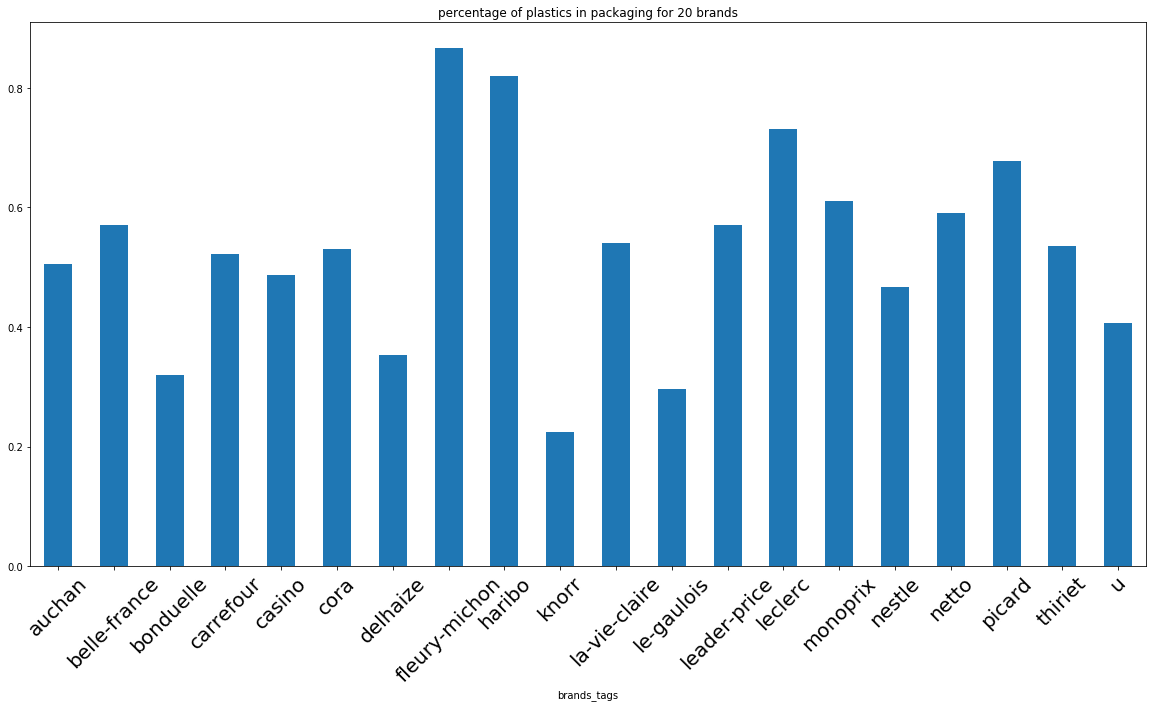

In [70]:
ax = data_major_brands_fr_cleaned_plastic_percentage.plot(kind="bar", figsize=(20,10), title= 'percentage of plastics in packaging for 20 brands')
ax.tick_params(axis='x', labelsize=20)
plt.xticks(rotation=45)

In [0]:
fig = ax.get_figure()
fig.savefig('/content/drive/My Drive/Ada Project/french_plastics.png', bbox_inches = 'tight')

We can see an interesting result, giving the percentage of plastics in the different brands' packaging. This top 20 shows a full range of brands, from very ecological to not at all, in terms of packaging of course.

##USA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

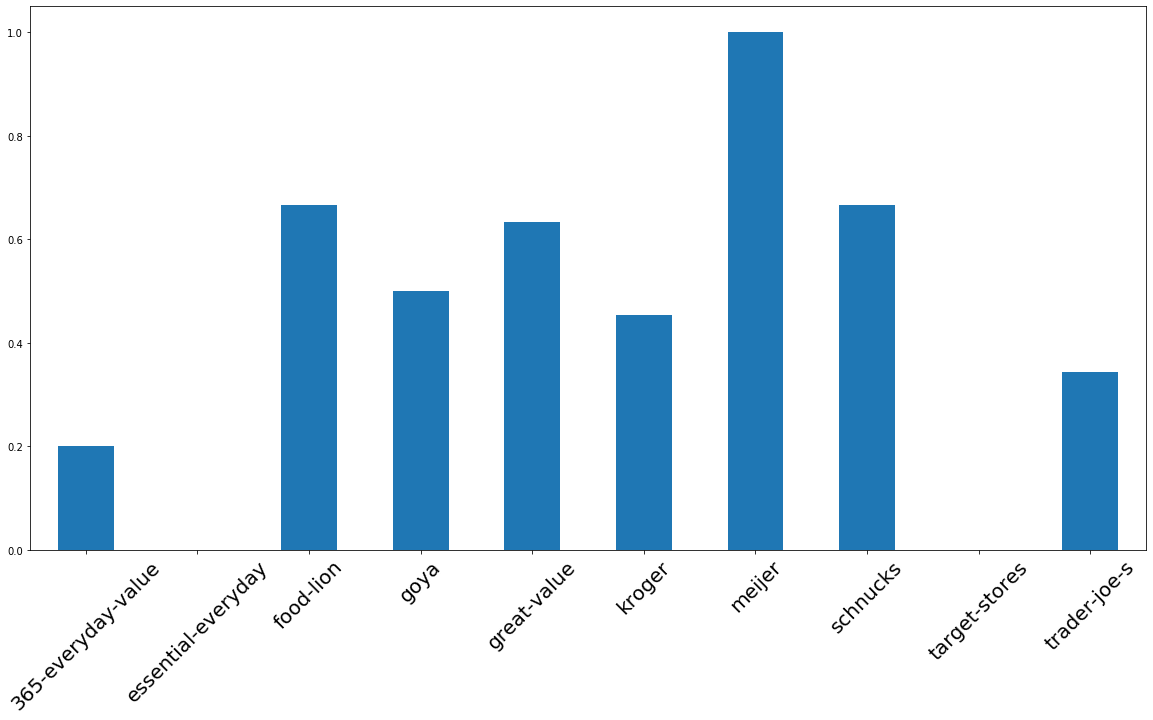

In [67]:
data_major_brands_us = data[data.brands_tags.isin(us_sample)]
data_major_brands_us_cleaned = data_major_brands_us[pd.notnull(data_major_brands_us['packaging'])]
data_major_brands_us_cleaned['packaging'] = data_major_brands_us_cleaned['packaging'].apply(lambda x: str(x).lower())
data_major_brands_us_cleaned_plastic = data_major_brands_us_cleaned[data_major_brands_us_cleaned['packaging'].apply(lambda x: fuzz.partial_ratio(x.lower(),"plastic")>60 or fuzz.partial_ratio(x.lower(),"kunststoff")>60 or fuzz.partial_ratio(x.lower(),"stück")>60)]
data_major_brands_us_cleaned_plastic = data_major_brands_us_cleaned_plastic.groupby('brands_tags').size()
data_major_brands_us_cleaned_plastic_percentage = data_major_brands_us_cleaned_plastic.sort_index().div(data_major_brands_us_cleaned.brands_tags.value_counts().sort_index(ascending = True))
ax_us = data_major_brands_us_cleaned_plastic_percentage.head(10).plot(kind="bar", figsize=(20,10))
ax_us.tick_params(axis='x', labelsize=20)
plt.xticks(rotation=45)

Surprisingly, we can note that none of the users that registered food from essential-everyday indicated the packaging type of the product, thus giving this result. Same for target-stores.

In [0]:
fig_us = ax_us.get_figure()
fig_us.savefig('/content/drive/My Drive/Ada Project/us_plastics.png', bbox_inches = 'tight')

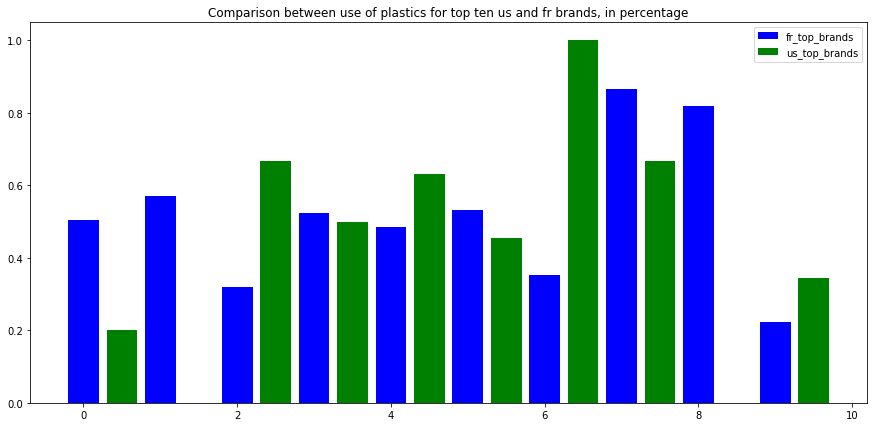

In [87]:
X = np.arange(10)
plt.figure(figsize=(15,7))
plt.bar(X + 0.0, data_major_brands_fr_cleaned_plastic_percentage.head(10), color = 'b', width = 0.4)
plt.bar(X + 0.5, data_major_brands_us_cleaned_plastic_percentage.head(10), color = 'g', width = 0.4)
plt.legend(['fr_top_brands', 'us_top_brands'])
#plt.xticks(X, sample_comp)
#plt.xticks(X + 0.5, data_major_brands_us_cleaned_plastic_percentage.sort_values(ascending=False).head(10).index)
#plt.xticks(rotation=45)
plt.title("Comparison between use of plastics for top ten us and fr brands, in percentage")
plt.show()

In [0]:
categories = data[['product_name','countries_en']].dropna()
categories_us = categories[categories['countries_en'] == 'United States']['product_name']
categories_fr = categories[categories['countries_en'] == 'France']['product_name']
categories_ch = categories[categories['countries_en'] == 'Switzerland']['product_name']

In [31]:
data['countries_en'].value_counts().sort_values(ascending = False)

France           379866
United States    101543
Spain             48959
Germany           26214
Switzerland       25182
                  ...  
Belize                1
Lesotho               1
England               1
Comoros               1
Tajikistan            1
Name: countries_en, Length: 157, dtype: int64

#Product trends

##Switzerland

In [32]:
topCategories_ch = categories_ch.value_counts()
topCategories_ch = topCategories_ch[topCategories_ch > 1]
topCategories_ch.index = topCategories_ch.index.str.lower()
topCategories_ch.head()

jus d'orange    31
mozzarella      30
jus de pomme    29
lait            22
lait entier     19
Name: product_name, dtype: int64

In [0]:
meats = pd.Series(['poulet', 'boeuf', 'veau', 'porc', 'mouton', 'agneau', 'chèvre', 'cheval', 'lapin', 'dinde'])
counts_ch = pd.Series([0,0,0,0,0,0,0,0,0,0])
i = 0
for m in meats:
  counts_ch[i] = topCategories_ch.index.str.contains(m,regex=False).sum()
  i = i + 1
counts_ch = counts_ch/counts_ch.sum()

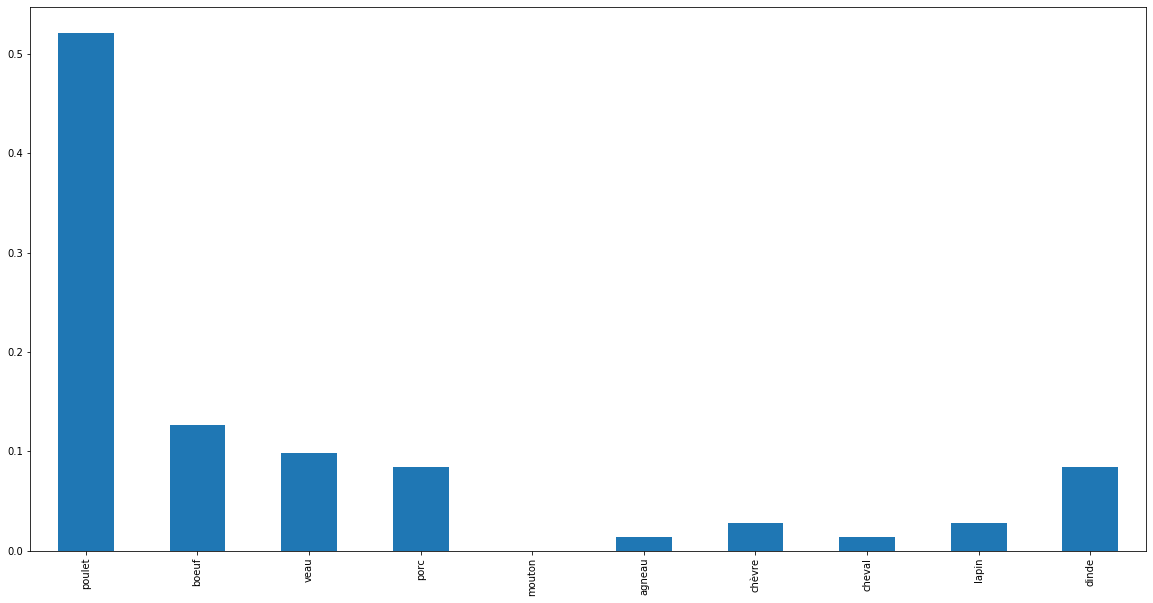

In [34]:
counts_ch.index = meats
plt.figure(figsize=(15,7))
counts_ch.plot(kind="bar", figsize=(20,10))

##France

In [35]:
topCategories_fr = categories_fr.value_counts()
topCategories_fr = topCategories_fr[topCategories_fr > 3]
topCategories_fr.index = topCategories_fr.index.str.lower()
topCategories_fr.shape[0]

8045

In [36]:
topCategories_fr.head(20)

jus de pomme           322
filet de poulet        242
jus d'orange           226
ketchup                174
saumon fumé            164
pain complet           160
filets de poulet       160
poulet                 158
spaghetti              153
mozzarella             149
merguez                148
jambon                 147
limonade               145
pois chiches           142
yaourt                 126
chipolatas             124
moutarde de dijon      123
terrine de campagne    114
escalope de dinde      113
houmous                111
Name: product_name, dtype: int64

In [0]:
counts = pd.Series([0,0,0,0,0,0,0,0,0,0])
i = 0
for m in meats:
  counts[i] = topCategories_fr.index.str.contains(m,regex=False).sum()
  i = i + 1
counts = counts/counts.sum()

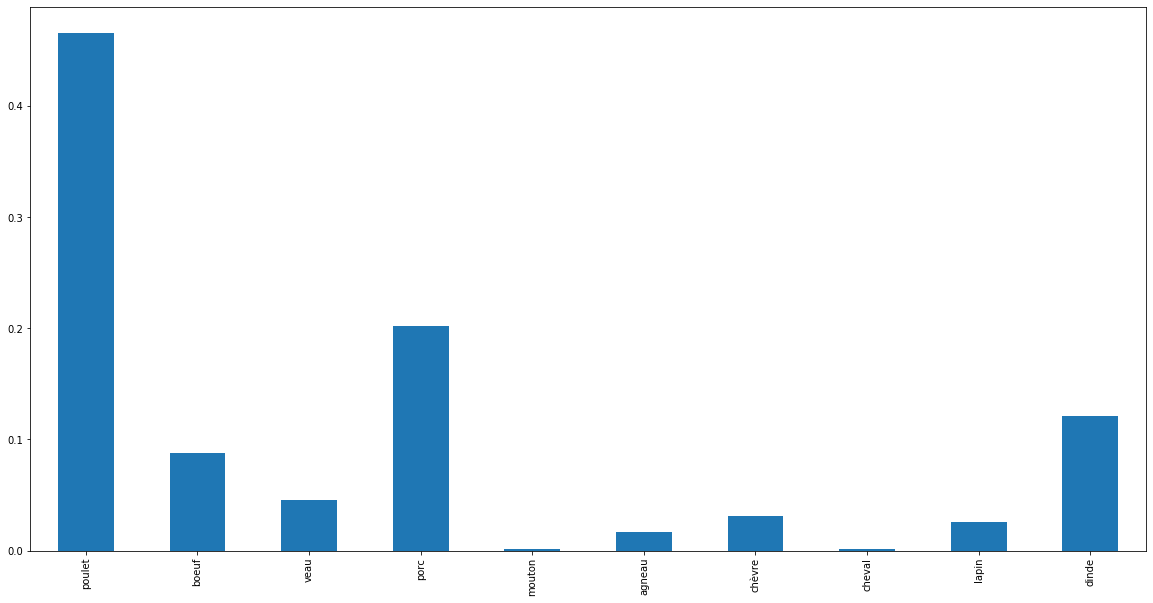

In [38]:
counts.index = meats
plt.figure(figsize=(15,7))
counts.plot(kind="bar", figsize=(20,10))

##United States

In [39]:
topCategories_us = categories_us.value_counts()
topCategories_us = topCategories_us[topCategories_us > 1]
topCategories_us.index = topCategories_us.index.str.lower()
topCategories_us.head(20)

ice cream              407
premium ice cream      220
salsa                  147
tomato sauce           127
cut green beans        127
apple sauce            114
pinto beans            110
tomato ketchup         106
greek nonfat yogurt    106
pasta sauce            105
chicken broth          104
black beans            102
soda                   100
cottage cheese          94
2% reduced fat milk     92
sweet peas              90
diced tomatoes          88
mixed vegetables        85
bbq sauce               81
gelato                  78
Name: product_name, dtype: int64

In [0]:
meats_us = pd.Series(['chicken', 'beef', 'veal', 'pork', 'mutton', 'lamb', 'goat', 'horse', 'rabbit', 'turkey'])
counts_us = pd.Series([0,0,0,0,0,0,0,0,0,0])
i = 0
for m in meats_us:
  counts_us[i] = topCategories_us.index.str.contains(m,regex=False).sum()
  i = i + 1
counts_us = counts_us/counts_us.sum()

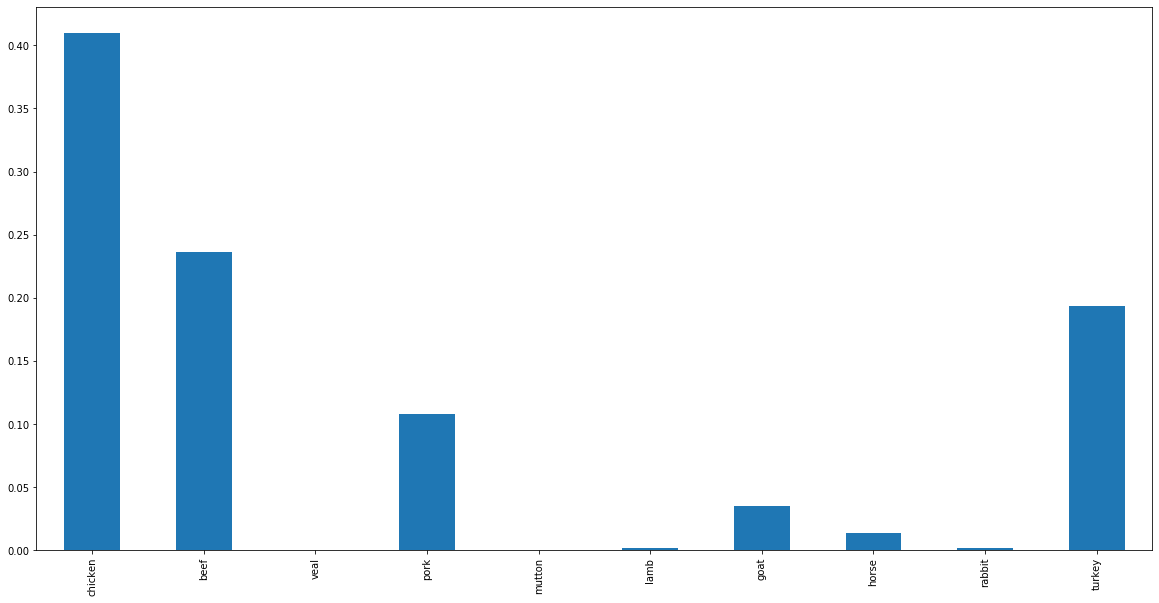

In [41]:
counts_us.index = meats_us
plt.figure(figsize=(15,7))
counts_us.plot(kind="bar", figsize=(20,10))

##Comparison between France, the US and Switzerland

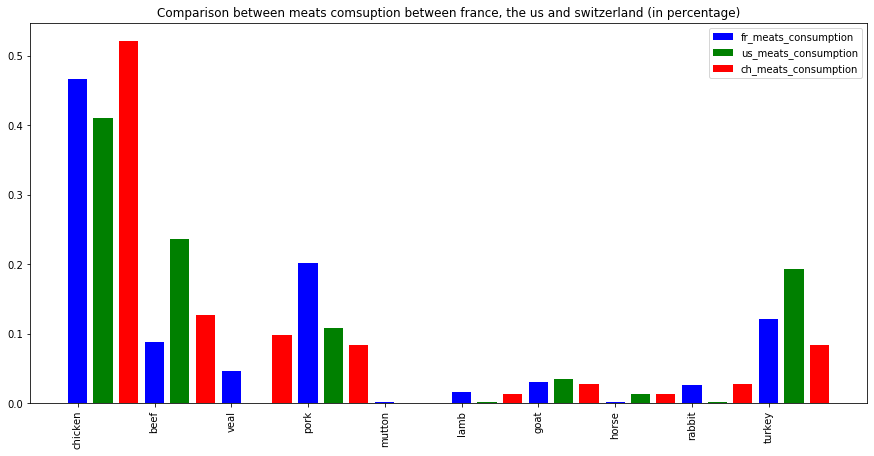

In [42]:
X = np.arange(10)

plt.figure(figsize=(15,7))
plt.bar(X + 0.0, counts, color = 'b', width = 0.25)
plt.bar(X + 0.33, counts_us, color = 'g', width = 0.25)
plt.bar(X + 0.66, counts_ch, color = 'r', width = 0.25)
plt.legend(['fr_meats_consumption', 'us_meats_consumption', 'ch_meats_consumption'])
plt.xticks(X, counts_us.index)
plt.xticks(rotation='vertical')
plt.title("Comparison between meats comsuption between france, the us and switzerland (in percentage)")
plt.show()

We can see with this graph, that there are little differences in meat consumption between the users of the database. However, we can see that us users buy more beef and more turkey. But french users buy more pork. We can also see that this dataset is representative of the overall dominance of chicken among meats. Indeed we know that chicken is by far the most popular meat in the world.